In [1]:
# Define dataset
import torch
import numpy as np
import platform
from os import path
import os

from PIL import Image
from torchvision import transforms
from numpy import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Dataset(torch.utils.data.Dataset):

    def __init__(self, annotations_frame,
                 path_to_slides,
                 crop_size = (128,128),
                 pseudo_epoch_length:int = 1000,
                 transformations = None):
        
        super().__init__()
        
        if platform.system() == 'Linux':
            self.separator = '/'
        else:
            self.separator = '\\'

        self.anno_frame = annotations_frame
        self.path_to_slides = path_to_slides
        self.crop_size = crop_size
        self.pseudo_epoch_length = pseudo_epoch_length
        
        # list which holds annotations of all slides in slide_names in the format
        # slide_name, annotation, label, min_x, max_x, min_y, max_y
        
        self.slide_dict, self.annotations_list = self._initialize()
        self.sample_cord_list = self._sample_cord_list()

        # set up transformations
        self.transformations = transformations
        self.transform_to_tensor = transforms.Compose([transforms.ToTensor()])


    def _initialize(self):
        # open all images and store them in self.slide_dict with their name as key value
        slide_dict = {}
        annotations_list = []
        for slide in self.anno_frame['filename'].unique():
            # open slide
            slide_dict[slide] =  Image.open(path.join(self.path_to_slides, slide)).convert('RGB')
            im_obj = Image.open(self.path_to_slides + self.separator + slide).convert('RGB')
            slide_dict[slide] = im_obj
            # setting up a list with all bounding boxes
            for idx,annotations in self.anno_frame[self.anno_frame.filename == slide][['max_x','max_y','min_x','min_y','label']].iterrows():
                annotations_list.append([slide, annotations['label'], annotations['min_x'], annotations['min_y'], annotations['max_x'], annotations['max_y']])

        return slide_dict, annotations_list


    def __getitem__(self,index):
        slide, x_cord, y_cord = self.sample_cord_list[index]
        x_cord = np.int64(x_cord)
        y_cord = np.int64(y_cord)
        # load image
        img = self.slide_dict[slide].crop((x_cord,y_cord,x_cord + self.crop_size[0],y_cord + self.crop_size[1]))
        # transform image
        #img = self.transformations(img)
        
        # load boxes for the image
        labels_boxes = self._get_boxes_and_label(slide,x_cord,y_cord)
        
        labels_boxes = [[i[1] - x_cord, i[2] - y_cord, i[3] - x_cord, i[4] - y_cord] + [i[0]] for i in labels_boxes]
        is_crowd = torch.zeros(len(labels_boxes))
        area = [torch.tensor((coordinates[2] - coordinates[0]) * (coordinates[3] - coordinates[1])) for coordinates in labels_boxes]
        # applay transformations
        if self.transformations != None:
            if len(labels_boxes) > 0:
                transformed = self.transformations(image = np.array(img), bboxes = labels_boxes)
                boxes = torch.tensor([line[:-1] for line in transformed['bboxes']], dtype = torch.float32)
                labels = torch.ones(boxes.shape[0], dtype = torch.int64)
                img = self.transform_to_tensor(transformed['image'])
                
            # check if there is no labeld instanceb on the image
            if len(labels_boxes) == 0:
                labels = torch.tensor([0], dtype = torch.int64)
                boxes = torch.zeros((0,4),dtype = torch.float32)
                img = self.transform_to_tensor(img)

        else:
            if len(labels_boxes) == 0:
                labels = torch.tensor([0], dtype = torch.int64)
                boxes = torch.zeros((0,4),dtype = torch.float32)
                img = self.transform_to_tensor(img)
            else:
                # now, you need to change the originale box cordinates to the cordinates of the image
                boxes = torch.tensor([line[:-1] for line in labels_boxes],dtype=torch.float32)
                labels = torch.ones(boxes.shape[0], dtype = torch.int64)
                img = self.transform_to_tensor(img)
        
        num_boxes = len(labels_boxes)
        boxes = torch.reshape(boxes, shape=(num_boxes, 4))

        
        target = {
            'image_id': torch.tensor(index).to(device),
            'boxes': boxes.to(device),
            'labels':labels.to(device),
            'iscrowd' : is_crowd.to(device),
            'area' : torch.tensor(area).to(device)
        }


        return img.to(device), target
        

    def _sample_cord_list(self):
        # select slides from which to sample an image
        slide_names = np.array(list(self.slide_dict.keys()))
        slide_indice = random.choice(np.arange(len(slide_names)), size = self.pseudo_epoch_length, replace = True)
        slides = slide_names[slide_indice]
        # select coordinates from which to load images
        # only works if all images have the same size
        width,height = self.slide_dict[slides[0]].size
        cordinates = random.randint(low = (0,0), high=(width - self.crop_size[0], height - self.crop_size[1]), size = (self.pseudo_epoch_length,2))
        return np.concatenate((slides.reshape(-1,1),cordinates), axis = -1)

    def __len__(self):
        return self.pseudo_epoch_length

    def _get_boxes_and_label(self,slide,x_cord,y_cord):
        return [line[1::] for line in self.annotations_list if line[0] == slide and line[2] > x_cord and line [3] > y_cord and line[4] < x_cord + self.crop_size[0] and line[5] < y_cord + self.crop_size[1]]
       
    @staticmethod
    def collate_fn(batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
        This describes how to combine these tensors of different sizes. We use lists.
        Note: this need not be defined in this Class, can be standalone.
        :param batch: an iterable of N sets from __iter__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        targets = list()

        for b in batch:
            images.append(b[0])
            targets.append(b[1])
            
            
        images = torch.stack(images, dim=0)

        return images, targets

    def trigger_sampling(self):
        self.sample_cord_list = self._sample_cord_list()

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_FPN_Weights
# Step 1: Initialize model with the best available weights
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT)


# replace the classifier with a new one, that has
# num_classes which is 2 for this case
num_classes = 2  # 1 class (cell) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [3]:
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils # See reference for source
from coco_eval import CocoEvaluator # See reference for source
from coco_utils import get_coco_api_from_dataset # See reference for source


# Reference: https://github.com/pytorch/vision/tree/main/references/detection

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator



In [4]:
from google.colab import drive

# path to the link you created
path_to_slides = '/content/gdrive/MyDrive/AgNOR_Project/images/'

# mount the data
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
import pandas as pd
from torch.utils.data import DataLoader

annotation_frame_path = "/content/gdrive/MyDrive/AgNOR_Project/annotation_frame.p"

annotation_frame = pd.read_pickle(annotation_frame_path)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc'))

# Split the annotation frame into train/test split
total_unique_images = annotation_frame['filename'].unique()
# Make an 80/20 split
train_images = math.floor(0.8 * len(total_unique_images))

train_data_images = total_unique_images[:train_images] 

test_data_images = total_unique_images[train_images:]

# Now the images have been split, next step split the annotation frame for these
# images
training_frame = annotation_frame[annotation_frame['filename'].isin(train_data_images)]
testing_frame = annotation_frame[annotation_frame['filename'].isin(test_data_images)]

# Create Data loader object
train_dataset = Dataset(training_frame, path_to_slides,crop_size=(128, 128), transformations=transform)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0, collate_fn=Dataset.collate_fn)

test_dataset = Dataset(testing_frame, path_to_slides, crop_size=(128, 128))

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0, collate_fn=Dataset.collate_fn)



In [7]:
# For Training
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]
predictions = model(x) 
print(predictions)

[{'boxes': tensor([[  8.2269,  22.6133, 338.9083, 254.9515]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5755], device='cuda:0', grad_fn=<IndexBackward0>)}, {'boxes': tensor([[ 51.6397,  31.1697, 400.0000, 367.9121],
        [  0.0000, 114.0533, 323.2059, 500.0000]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6131, 0.4990], device='cuda:0', grad_fn=<IndexBackward0>)}]


In [8]:
import torch.nn as nn
import torch.optim as optim

# Train model for 10 epochs
num_epochs = 10
# Loss function is the Cross Entropy loss
criterion = nn.BCELoss()

# Use Adam optimizer with amsgrad

# Find only the parameters of the new head which need to be trained
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001, amsgrad=True)


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    optimizer.step()
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)


Epoch: [0]  [  0/200]  eta: 0:01:17  lr: 0.000001  loss: 1.5480 (1.5480)  loss_classifier: 0.8535 (0.8535)  loss_box_reg: 0.4802 (0.4802)  loss_objectness: 0.1988 (0.1988)  loss_rpn_box_reg: 0.0155 (0.0155)  time: 0.3898  data: 0.0233  max mem: 2642
Epoch: [0]  [ 10/200]  eta: 0:00:43  lr: 0.000006  loss: 1.4710 (1.4771)  loss_classifier: 0.7881 (0.7806)  loss_box_reg: 0.4955 (0.5136)  loss_objectness: 0.1655 (0.1667)  loss_rpn_box_reg: 0.0142 (0.0162)  time: 0.2273  data: 0.0162  max mem: 2926
Epoch: [0]  [ 20/200]  eta: 0:00:39  lr: 0.000011  loss: 1.3853 (1.4129)  loss_classifier: 0.6617 (0.6775)  loss_box_reg: 0.5745 (0.5898)  loss_objectness: 0.1163 (0.1321)  loss_rpn_box_reg: 0.0119 (0.0135)  time: 0.2108  data: 0.0152  max mem: 2926
Epoch: [0]  [ 30/200]  eta: 0:00:36  lr: 0.000016  loss: 1.2126 (1.3239)  loss_classifier: 0.4778 (0.5985)  loss_box_reg: 0.6476 (0.6057)  loss_objectness: 0.0737 (0.1075)  loss_rpn_box_reg: 0.0081 (0.0122)  time: 0.2065  data: 0.0146  max mem: 2926


In [10]:
# Save the model and then visualise some predictions from the model compared to ground truth
torch.save(model, "/content/gdrive/MyDrive/AgNOR_Project/model")

# Change model to inference mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

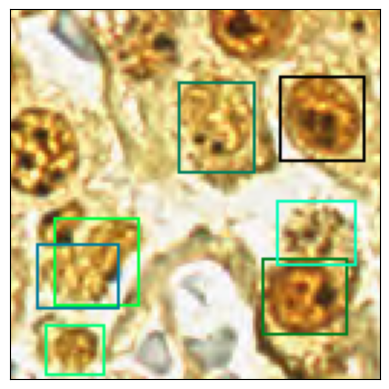

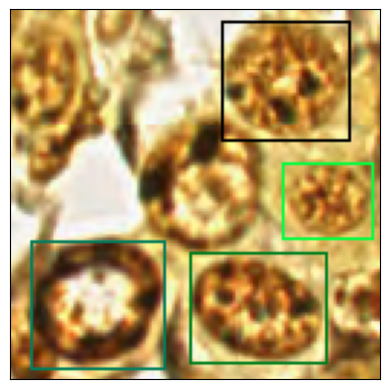

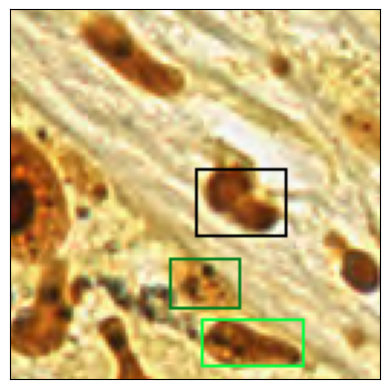

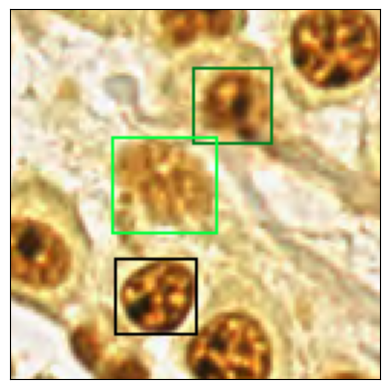

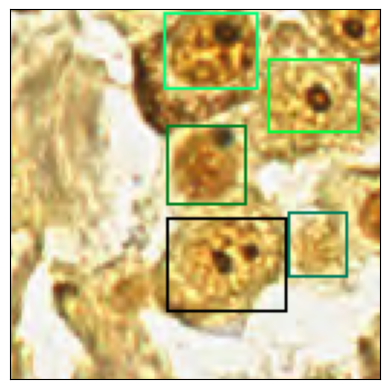

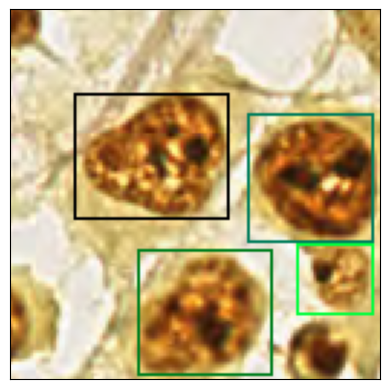

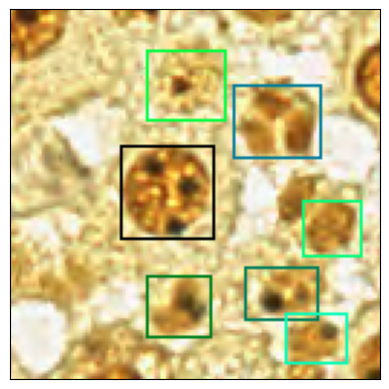

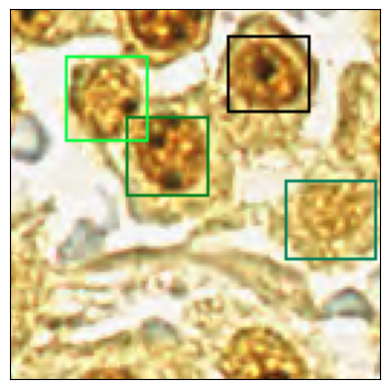

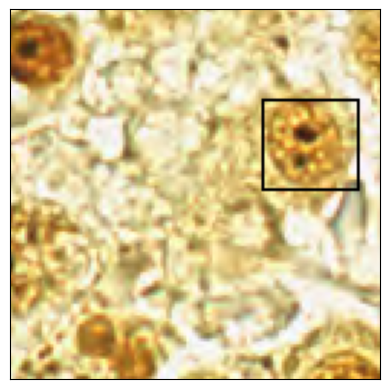

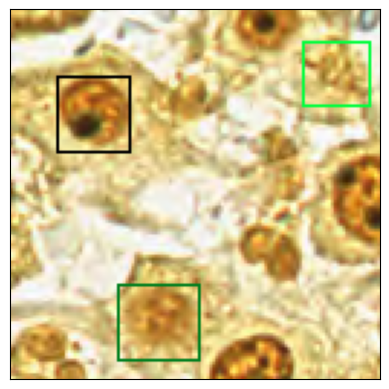

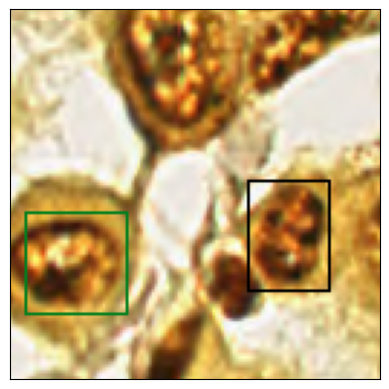

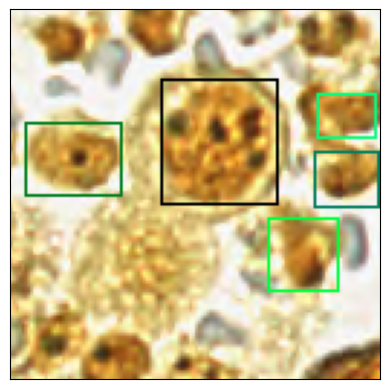

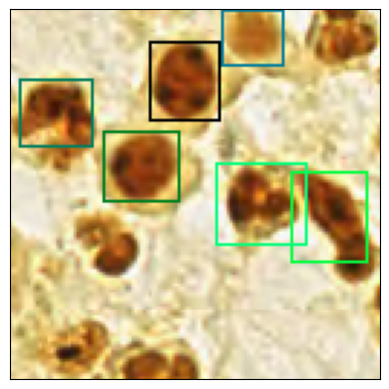

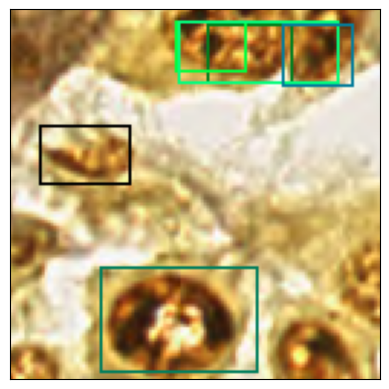

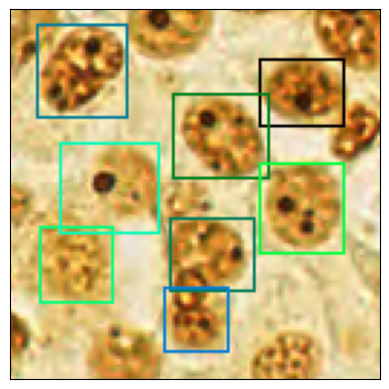

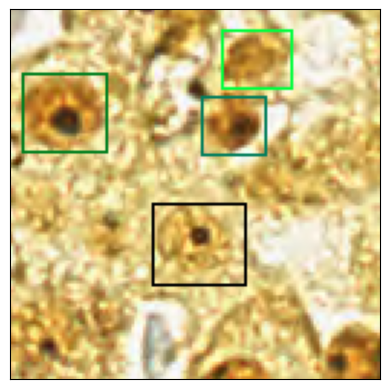

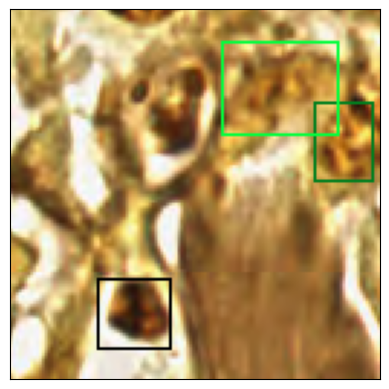

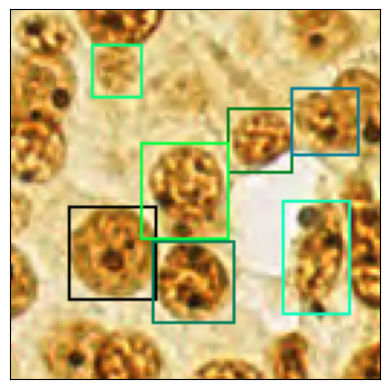

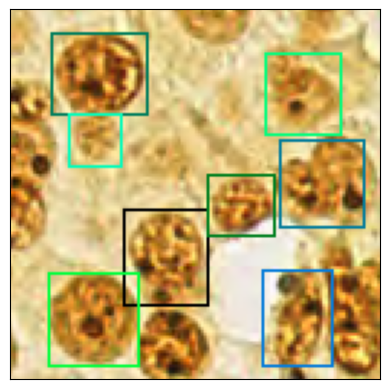

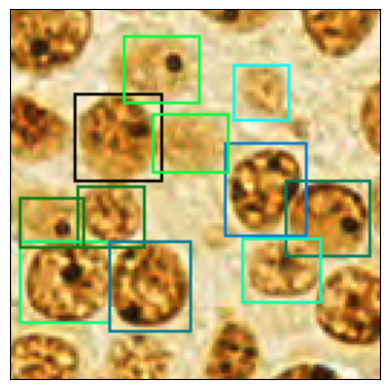

In [17]:
# From pytorch docs
from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


# Show predicted bounding boxes

for i in range(4):
  # Load any image from the test set
  images,targets = next(iter(test_loader))
  images = list(image for image in images)
  targets = [{k: v for k, v in t.items()} for t in targets]

  predictions = model(images)
  for index, img in enumerate(images):
    result = draw_bounding_boxes(F.convert_image_dtype(img, dtype=torch.uint8), predictions[index]['boxes'], width=1)
    show(result)
